# **Sentimen Analisis Aplikasi Pintu (APK Play Store)**

Aplikasi Pintu telah menjadi salah satu platform populer di Indonesia untuk membeli dan berinvestasi dalam aset kripto. Seiring dengan meningkatnya minat masyarakat terhadap mata uang digital, penting untuk memahami bagaimana pengguna merasakan pengalaman mereka menggunakan aplikasi ini. Analisis sentimen ini bertujuan untuk mengevaluasi opini dan emosi pengguna Pintu yang tercermin dalam berbagai sumber data, memberikan wawasan mengenai aspek-aspek yang dianggap positif maupun negatif. Hasil analisis ini diharapkan dapat memberikan gambaran komprehensif mengenai persepsi pengguna terhadap aplikasi Pintu.

# **Import Library**

In [1]:
!pip install sastrawi

In [24]:
# === Standard Library ===
import re
import string
import datetime as dt
import csv
import requests
from io import StringIO

# === Data Handling ===
import pandas as pd
import numpy as np

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# === NLP (Natural Language Processing) ===
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# === Machine Learning ===
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# **Loading Dataset**

In [3]:
# Membaca file CSV yang sudah disimpan sebelumnya
df = pd.read_csv('ulasan_pintu.csv', encoding='utf-8-sig', escapechar='\\') # Added escapechar parameter
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,c64139b9-9183-4965-bb56-6423c1e88a77,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasi Pintu enak banget dipake nya! Tampila...,5,7,3.70.0,2025-04-09 11:57:38,"Hi Kak, terima kasih atas review dan komentar ...",2025-04-11 09:04:50,3.70.0
1,74a2c788-7560-4b35-8440-907539a248ab,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,aplikasi yang sangat bagus bagi pemula dan car...,5,9,3.70.0,2025-04-09 08:03:10,"Hi Kak, kami mohon maaf atas kendala yang Kaka...",2025-04-09 08:22:27,3.70.0
2,840bbc53-fe6b-4a42-b324-436e5ab50a6f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Saya sudah menggunakan aplikasi Pintu untuk in...,5,1,3.70.0,2025-04-09 08:57:02,"\nHi Kak, terima kasih atas review dan komenta...",2025-04-11 09:05:28,3.70.0
3,681badb8-6a90-487c-8d20-1c7c55afb7db,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Awalnya cuma coba-coba karena gak tega duit le...,5,0,3.70.0,2025-04-10 01:05:09,"Hi Kak, terimakasih atas review dan komentar p...",2025-04-10 09:16:27,3.70.0
4,28ac6ff0-4751-49b2-8428-5086f41b2e88,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Sangat, direkomendasikan untuk pemula, seperti...",5,44,3.69.0,2025-03-14 14:14:46,"Hi Kak, terima kasih atas review dan komentar ...",2025-03-14 16:31:04,3.69.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30763 entries, 0 to 30762
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              30763 non-null  object
 1   userName              30763 non-null  object
 2   userImage             30763 non-null  object
 3   content               30763 non-null  object
 4   score                 30763 non-null  int64 
 5   thumbsUpCount         30763 non-null  int64 
 6   reviewCreatedVersion  23732 non-null  object
 7   at                    30763 non-null  object
 8   replyContent          24502 non-null  object
 9   repliedAt             24502 non-null  object
 10  appVersion            23732 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.6+ MB


In [5]:
# Hapus duplikat berdasarkan kolom 'content' dan ambil 10.000 data acak
df_cleaned = df.drop_duplicates(subset='content').sample(n=10000, random_state=42)

# Tampilkan jumlah data setelah penghapusan duplikat dan pengambilan sampel acak
print("Jumlah data setelah dihapus duplikat dan dibatasi 10.000:", len(df_cleaned))

Jumlah data setelah dihapus duplikat dan dibatasi 10.000: 10000


# **Preprocessing**

In [6]:
# ========== CLEANING ==========
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # remove mentions
    text = re.sub(r'#\w+', '', text)            # remove hashtags
    text = re.sub(r'RT[\s]+', '', text)         # remove RT
    text = re.sub(r"http\S+", '', text)         # remove links
    text = re.sub(r'\d+', '', text)             # remove numbers
    text = re.sub(r'[^\w\s]', '', text)         # remove punctuation
    text = text.replace('\n', ' ')              # replace newline
    text = text.strip()                         # trim whitespaces
    return text

# ========== CASEFOLDING ==========
def casefoldingText(text):
    return text.lower()

# ========== TOKENIZING ==========
def tokenizingText(text):
    return word_tokenize(text)

# ========== STOPWORD REMOVAL ==========
def filteringText(tokens):
    # Default stopwords
    stop_words = set(stopwords.words('indonesian'))
    stop_words.update(stopwords.words('english'))

    # Tambahan kata tidak bermakna (slang atau umum)
    stop_words.update([
        'iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku', 'di', 'ga', 'ya',
        'loh', 'kah', 'woi', 'woy'
    ])

    # Custom stopwords berdasarkan domain (crypto + aplikasi)
    custom_stopwords = [
        'apk', 'fitur', 'fiturnya', 'fitur2', 'aplikasi', 'aplikasinya', 'akun', 'akunmu', 'pintu',
        'pakai', 'pake', 'pakainya', 'masuk', 'buka', 'login', 'logout', 'daftar',
        'saldo', 'uang', 'duit', 'harga', 'transaksi', 'withdraw', 'wd', 'deposit', 'kirim',
        'tarik', 'koin', 'token', 'aset', 'asetku', 'crypto', 'cryptocurrency',
        'trading', 'wallet', 'ewallet', 'email', 'akun', 'verifikasi', 'akunmu',
        'nomor', 'nomornya', 'kode', 'otp', 'ktp', 'ktpn', 'foto', 'update', 'scan', 'bintang',
        'mobile', 'versi', 'app', 'playstore', 'store', 'indodax', 'ovo', 'dana', 'gopay', 'bni',
        'bca', 'mandiri', 'bjb', 'jaringan', 'koneksi', 'koneksi', 'web', 'website', 'situs',
        'download', 'install', 'hapus', 'hapusnya', 'nambah', 'nambahin', 'tambahan', 'tambahin',
        'tambahin', 'kasih', 'tolong', 'help', 'please', 'mohon', 'moga', 'semoga', 'harap', 'harapan',
        'banget', 'saja', 'aja', 'kok', 'deh', 'dong', 'nih', 'juga', 'lagi', 'malah', 'udah',
        'sudah', 'belum', 'baru', 'lama', 'sama', 'tetap', 'akan', 'dengan', 'tanpa', 'tentang',
        'untuk', 'karena', 'padahal', 'jadi', 'cuma', 'bahkan', 'namun', 'meskipun', 'apalagi',
        'dan', 'atau', 'yang', 'ini', 'itu', 'itu', 'bgt', 'aja', 'btw'
    ]

    stop_words.update(custom_stopwords)

    # Filter token
    return [word for word in tokens if word not in stop_words]


# ========== STEMMING ==========
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemmingText(tokens):
    return [stemmer.stem(word) for word in tokens]

# ========== CONVERT TO SENTENCE ==========
def toSentence(tokens):
    return ' '.join(tokens)

In [7]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [8]:
def preprocess(text):
    text = cleaningText(text)
    text = casefoldingText(text)
    text = fix_slangwords(text)
    tokens = tokenizingText(text)
    tokens = filteringText(tokens)
    tokens = stemmingText(tokens)
    final_text = toSentence(tokens)
    return final_text

In [9]:
# Proses teks dari kolom 'content' menggunakan preprocessing
df_cleaned['cleaned_text'] = df_cleaned['content'].apply(preprocess)

In [10]:
df_cleaned.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,cleaned_text
23429,48e0a71e-f2b1-4780-98c4-8d77033b1642,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Investasi Crypto di Pintu ternyata beneran gam...,5,1,3.49.0,2024-05-21 08:51:18,"Hi Kak, terima kasih atas review dan komentar ...",2024-05-20 16:30:46,3.49.0,investasi beneran gampang pilih cryptonya sedi...
21423,fdbc8ec1-8c41-44dc-89ae-aebf5b3dcba3,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Mantab dpt 50k,5,0,3.7.1,2021-11-19 10:36:28,NaN,NaN,3.7.1,mantab
641,25bfe4d6-c2e0-459b-9b6d-55b5053bf713,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,terimakasih kasih pintu......lengkap dan mudah...,5,0,3.68.1,2025-03-10 04:09:41,"Hi Kak, terimakasih atas review dan komentar p...",2025-03-10 08:43:17,3.68.1,terimakasih pintulengkap mudah gunakandan rewa...
18320,1f6abb27-8bc5-445c-beaf-62ce69574066,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sangat memuaskan,5,0,3.55.0,2024-08-15 08:46:36,"Hi Kak, terima kasih atas review dan komentar ...",2024-08-15 16:35:50,3.55.0,muas
199,29513d0b-7fe6-40a9-aad5-48319c74e24b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Apk pintu ini sangat bagus, rekomdet banget si...",5,1,3.66.0,2025-02-07 01:22:58,"Hi Kak, terimakasih atas review dan komentar p...",2025-02-07 07:43:35,3.66.0,bagus rekomdet beli qripto investasi berita ha...


# **Pelabelan dan Ekstraksi Fitur**

## Pelabelan

In [11]:
# Loads positive lexicon data from GitHub
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Loads negative lexicon data from GitHub
# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya ke dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [12]:
custom_negative = {
    "tipu": 3,
    "kecewa": 3,
    "payah": 2,
    "scam": 2,
    "gagal": 2,
    "verifikasi": 1,
    "maintenance": 1,
    "lambat": 4,
    "banned": 2,
    "error": 3,
    "update": 1,
    "tolak": 1,
    "sebal": 1,
    "susah": 1,
    "ngecewain": 3,
    "kecewanya": 3,
    "gagalnya": 2,
    "rugi": 2,
    "lambatnya": 1,
    "lambatin": 1,
    "errors": 3,
    "eror": 3,
    "lag": 1,
    "jelek": 5
}


# Gabungkan dengan lexicon_negative
lexicon_negative.update(custom_negative)

In [13]:
def hybrid_sentiment_labeling(text):
    score_lexicon = 0
    tokens = text.split()

    for word in tokens:
        if word in lexicon_positive:
            score_lexicon += lexicon_positive[word]
        elif word in lexicon_negative:
            score_lexicon -= lexicon_negative[word]

    # Aturan pelabelan murni dari lexicon
    if score_lexicon >= 1:
        label = 'positive'
    elif score_lexicon <= -1:
        label = 'negative'
    else:
        label = 'neutral'

    return score_lexicon, label

In [14]:
df_cleaned[['score_lexicon', 'label_hybrid']] = df_cleaned.apply(
    lambda row: pd.Series(hybrid_sentiment_labeling(row['cleaned_text'])),
    axis=1
)

In [15]:
df_cleaned['label_hybrid'].value_counts()

,count
label_hybrid,
positive,8373
neutral,1392
negative,235


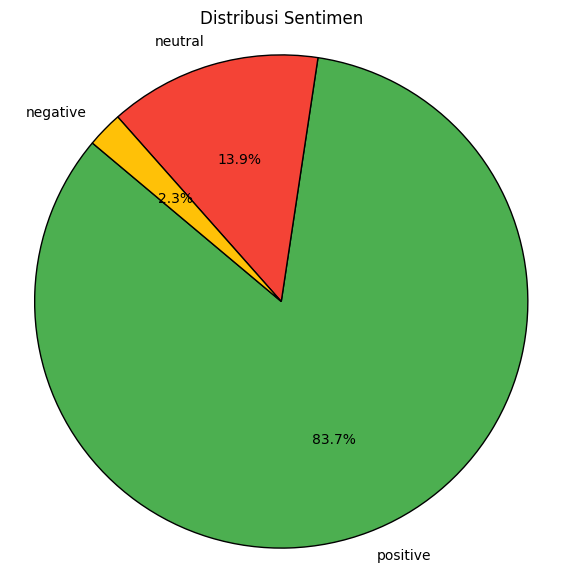

In [16]:
# Hitung jumlah data untuk tiap label
sentiment_counts = df_cleaned['label_hybrid'].value_counts()

# Warna custom (opsional)
colors = ['#4CAF50', '#F44336', '#FFC107']  # Hijau, Merah, Kuning

# Pie chart
plt.figure(figsize=(7, 7))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Distribusi Sentimen')
plt.axis('equal')  # Buat pie jadi bulat
plt.show()


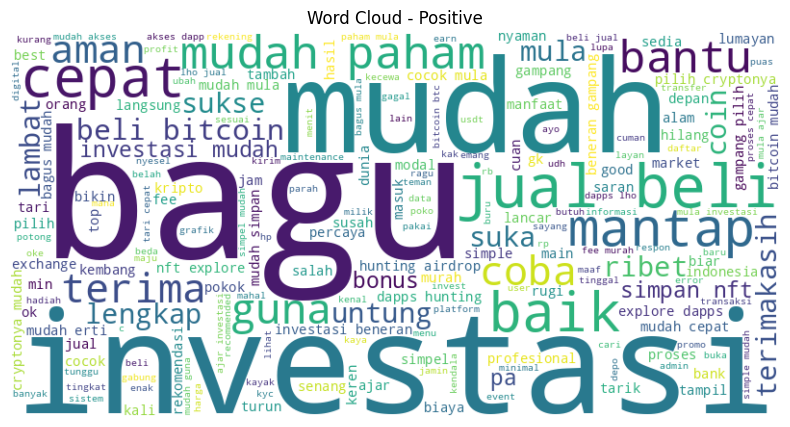

In [17]:
# Gabungkan semua teks positif
text_positive = ' '.join(df_cleaned[df_cleaned['label_hybrid'] == 'positive']['cleaned_text'])

# Buat Word Cloud
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(text_positive)

# Tampilkan
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Positive')
plt.show()

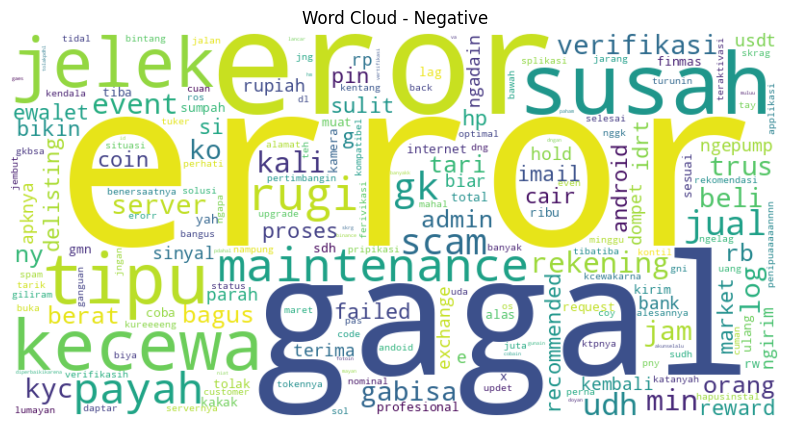

In [18]:
# Gabungkan semua teks negatif
text_negative = ' '.join(df_cleaned[df_cleaned['label_hybrid'] == 'negative']['cleaned_text'])

# Buat Word Cloud
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(text_negative)

# Tampilkan
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Negative')
plt.show()


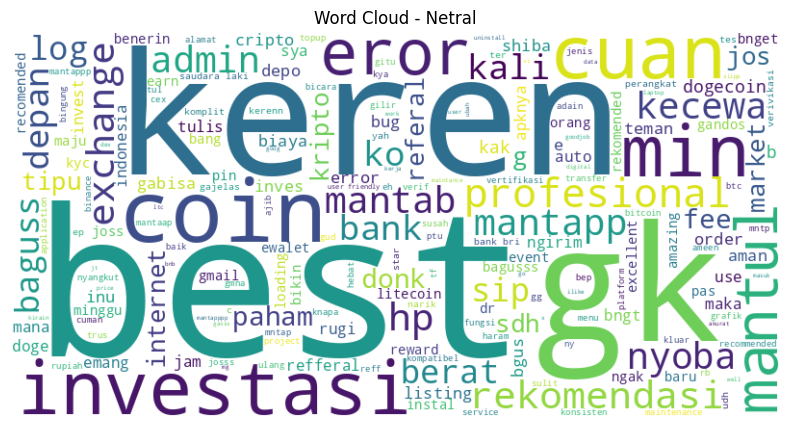

In [19]:
# Gabungkan semua teks neutral
text_negative = ' '.join(df_cleaned[df_cleaned['label_hybrid'] == 'neutral']['cleaned_text'])

# Buat Word Cloud
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(text_negative)

# Tampilkan
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Netral')
plt.show()


## Ekstraksi Fitur

In [20]:
# Ambil teks dan label
texts = df_cleaned['cleaned_text']
labels = df_cleaned['label_hybrid']

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=1000, min_df=17, max_df=0.8 )
X = tfidf.fit_transform(texts)  # hasi fitur
y = labels  # label target

In [21]:
# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())

features_df

,academy,admin,adminnya,agam,airdrop,ajar,akses,aktif,alam,alamat,...,user,userfriendly,utama,verifikasi,via,wajib,walet,wow,yah,yuk
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Data Spliting dan Pemodelan**

## Data Spliting

In [22]:
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest

In [25]:
# Membuat objek model Random Forest
random_forest = RandomForestClassifier()

# Melatih model Random Forest pada data pelatihan
random_forest.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = random_forest.predict(X_train.toarray())
y_pred_test_rf = random_forest.predict(X_test.toarray())

# Evaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)

# Menampilkan akurasi
print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 0.980125
Random Forest - accuracy_test: 0.939


## Logistic Regression

In [26]:
# Membuat objek model Logistic Regression
logistic_regression = LogisticRegression()

# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = logistic_regression.predict(X_train.toarray())
y_pred_test_lr = logistic_regression.predict(X_test.toarray())

# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.95575
Logistic Regression - accuracy_test: 0.933


## Decision Tree

In [27]:
# Membuat objek model Decision Tree
decision_tree = DecisionTreeClassifier()

# Melatih model Decision Tree pada data pelatihan
decision_tree.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_dt = decision_tree.predict(X_train.toarray())
y_pred_test_dt = decision_tree.predict(X_test.toarray())

# Evaluasi akurasi model Decision Tree
accuracy_train_dt = accuracy_score(y_pred_train_dt, y_train)
accuracy_test_dt = accuracy_score(y_pred_test_dt, y_test)

# Menampilkan akurasi
print('Decision Tree - accuracy_train:', accuracy_train_dt)
print('Decision Tree - accuracy_test:', accuracy_test_dt)

Decision Tree - accuracy_train: 0.980125
Decision Tree - accuracy_test: 0.936


In [28]:
# Membuat DataFrame untuk hasil akurasi
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'Decision Tree'],
    'Accuracy Train': [accuracy_train_rf, accuracy_train_lr, accuracy_train_dt],
    'Accuracy Test': [accuracy_test_rf, accuracy_test_lr, accuracy_test_dt]
})
# Menampilkan hanya kolom "Accuracy Test"
accuracy_test_only = results_df[['Model', 'Accuracy Test']]
print(accuracy_test_only)

                 Model  Accuracy Test
0        Random Forest          0.939
1  Logistic Regression          0.933
2        Decision Tree          0.936


In [29]:
# Mengurutkan DataFrame berdasarkan kolom "Accuracy Test" dari tertinggi ke terendah
accuracy_test_sorted = accuracy_test_only.sort_values(by='Accuracy Test', ascending=False)

# Menampilkan DataFrame yang telah diurutkan
print(accuracy_test_sorted)

                 Model  Accuracy Test
0        Random Forest          0.939
2        Decision Tree          0.936
1  Logistic Regression          0.933


# Testing


## Testing Random Forest

In [37]:
# Input kalimat baru dari pengguna
kalimat_baru = input("Masukkan kalimat baru: ")

# Melakukan preprocessing pada kalimat baru
kalimat_baru_cleaned = preprocess(kalimat_baru)

# Menggunakan objek tfidf yang sudah di-fit dari pelatihan sebelumnya
X_kalimat_baru = tfidf.transform([kalimat_baru_cleaned])

# Memperoleh prediksi sentimen kalimat baru
prediksi_sentimen = random_forest.predict(X_kalimat_baru)

# Menampilkan hasil prediksi
if prediksi_sentimen[0] == 'positive':
    print("Sentimen kalimat baru adalah POSITIF.")
elif prediksi_sentimen[0] == 'neutral':
    print("Sentimen kalimat baru adalah NETRAL.")
else:
    print("Sentimen kalimat baru adalah NEGATIF.")

Masukkan kalimat baru: aplikasinya sangat bagus dan bermanfaat untuk pemula seperti saya
Sentimen kalimat baru adalah POSITIF.


## Testing Logistic Regression


In [35]:
# Input kalimat baru dari pengguna
kalimat_baru = input("Masukkan kalimat baru: ")

# Melakukan preprocessing pada kalimat baru
kalimat_baru_cleaned = preprocess(kalimat_baru)

# Menggunakan objek tfidf yang sudah di-fit dari pelatihan sebelumnya
X_kalimat_baru = tfidf.transform([kalimat_baru_cleaned])

# Memperoleh prediksi sentimen kalimat baru
prediksi_sentimen = logistic_regression.predict(X_kalimat_baru)

# Menampilkan hasil prediksi
if prediksi_sentimen[0] == 'positive':
    print("Sentimen kalimat baru adalah POSITIF.")
elif prediksi_sentimen[0] == 'neutral':
    print("Sentimen kalimat baru adalah NETRAL.")
else:
    print("Sentimen kalimat baru adalah NEGATIF.")

Masukkan kalimat baru: saya kecewa, ini adalah aplikasi terjelek dan sering error
Sentimen kalimat baru adalah NEGATIF.


## Testing Decision Tree

In [36]:
# Input kalimat baru dari pengguna
kalimat_baru = input("Masukkan kalimat baru: ")

# Melakukan preprocessing pada kalimat baru
kalimat_baru_cleaned = preprocess(kalimat_baru)

# Menggunakan objek tfidf yang sudah di-fit dari pelatihan sebelumnya
X_kalimat_baru = tfidf.transform([kalimat_baru_cleaned])

# Memperoleh prediksi sentimen kalimat baru
prediksi_sentimen = decision_tree.predict(X_kalimat_baru)

# Menampilkan hasil prediksi
if prediksi_sentimen[0] == 'positive':
    print("Sentimen kalimat baru adalah POSITIF.")
elif prediksi_sentimen[0] == 'neutral':
    print("Sentimen kalimat baru adalah NETRAL.")
else:
    print("Sentimen kalimat baru adalah NEGATIF.")

Masukkan kalimat baru: pintu adalah aplikasi investasi
Sentimen kalimat baru adalah NETRAL.
